In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import random
from sklearn.metrics import f1_score, precision_score, recall_score, median_absolute_error, mean_absolute_error,mean_squared_error

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm
from tqdm.notebook import tqdm_notebook

import transformers
from transformers import AutoModel, AutoTokenizer
from transformers.models.bert import modeling_bert

# Functions used in all training notebooks

In [2]:
# Function to map hexbin plot colors
def my_reduce(x):
    npsum = np.sum(x)
    return np.log(npsum)


# Function to train model (1 epoch)
def train_model(model,input_function, train_loader, criterion, optimizer, verbose = False):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.train() # enable train mode
    running_loss = 0.0
    
    if verbose == 2:
        status = train_loader
    else:
        status = tqdm_notebook(train_loader, 0)
        
    for i, data in enumerate(status):
        # get the inputs; data is a tuple of lists [inputs, labels]
        inputs, labels = data
        input_tensors = input_function(inputs)
        labels =  labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = model(*input_tensors)
        loss = criterion(torch.squeeze(outputs).to(torch.float32),labels.to(torch.float32))
        loss.backward()
        optimizer.step()

        # print statistics
        if verbose !=2:
            running_loss += loss.item()
            if i % 500 == 499:    # print every 500 batches
                tqdm.write(f'Batch {i + 1:5d}    Loss: {running_loss / 500:.5f}')
                running_loss = 0.0

                
# Function to test model            
def test_model(model,input_function, test_loader, criterion, verbose = False):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.eval() # enable evaluation mode
    valid_loss = 0
    valid_preds, valid_labels = [], []
    
    if verbose == 2:
        status = test_loader
    else:
        status = tqdm_notebook(test_loader, 0)
        
    for i, data in enumerate(status):
        # get the inputs; data is a tuple of lists: [inputs, labels]
        inputs, labels = data
        input_tensors = input_function(inputs)
        labels =  labels.to(device)
        
        outputs = model(*input_tensors)
        loss = criterion(outputs[0].to(torch.float32),labels.to(torch.float32))
        valid_preds.append(outputs[0].cpu().detach().item())
        valid_labels.append(labels.cpu().detach().item())
        valid_loss += loss.item()

    valid_mse = mean_squared_error(valid_labels, valid_preds)
    valid_maerr = mean_absolute_error(valid_labels, valid_preds)
    
    if verbose !=2:
        print("\nTest Results:\nLoss: {:.6f}".format(valid_loss / len(test_loader)))
        print("Total Mean Squared Error: {:.4f}".format(valid_mse))
        print("Total Mean Absolute Error: {:.4f}\n".format(valid_maerr))

        # Plots

        # Prepare Hexbin plot
        temp_df = pd.DataFrame(zip(valid_preds,valid_labels), columns = ['Predicted values', 'Hops'])
        temp_df['Hops'] = 1/temp_df['Hops']
        temp_df['C'] = 1

        if verbose:
            fig, axes = plt.subplots(4,1, figsize = (10,20))
        else:
            fig, axes = plt.subplots(2,1, figsize = (10,10))

        temp_df.plot.hexbin(ax = axes[0], x ='Hops', y='Predicted values',C = 'C', reduce_C_function=my_reduce,colormap="viridis")
        axes[0].set_title("Hexbin Plot")
    
    # Calculate metrics per Hop
    mse = []
    mae = []
    high1_p=high_close_p=high_mid_p=high_far_p=high1_n=high_close_n=high_mid_n=high_far_n=0
    for i in range(1,30):
        target = 1/i
#         target = i
        preds = []
        trues = []
        for predicted, true in zip(valid_preds, valid_labels):
            if true == target:
                preds.append(predicted)
                trues.append(true)
                if predicted > 0.5:
                    if i==1:
                        high1_p +=1
                    elif i<4:
                        high_close_p +=1
                    elif i<11:
                        high_mid_p +=1
                    else:
                        high_far_p +=1
                else:
                    if i==1:
                        high1_n +=1
                    elif i<4:
                        high_close_n +=1
                    elif i<11:
                        high_mid_n +=1
                    else:
                        high_far_n +=1
        if len(trues)==0:
            continue
        mae.append(mean_absolute_error(trues, preds))
        mse.append(mean_squared_error(trues, preds))
        if i<4 and verbose != 2:
            print(" Hop '"+str(i)+"'\tMAE: {:.4f}, MSE: {:.4f}".format(mae[i-1],mse[i-1])) 
        if i==1:
            hist_preds = preds
    if high1_n == 0: high1_n=1
    if high_close_n == 0: high_close_n=1
    if high_mid_n == 0: high_mid_n=1
    if high_far_n == 0: high_far_n=1
    p1 = high1_p*100/(high1_p+high1_n)
    p2 = high_close_p*100/(high_close_p+high_close_n)
    p3 = high_mid_p*100/(high_mid_p+high_mid_n)
    p4 = high_far_p*100/(high_far_p+high_far_n)
    tp = high1_p
    tn = high_mid_n + high_far_n
    fp = high_mid_p + high_far_p
    fn = high1_n
    if fp == 0: fp = 1
    pseudo_precision = tp/(tp + fp)
    pseudo_recall = tp/(tp + fn)
    pseudo_accuracy = (tp + tn) / (tp + fn + tn +fp)
    if pseudo_recall == 0 and pseudo_precision == 0 :
        pseudo_f1 = 0
        f1g = 0
    else:
        pseudo_f1 = 2 * pseudo_precision * pseudo_recall / (pseudo_precision + pseudo_recall)
        proportion = (high1_n + high1_p)/(high_mid_p + high_mid_n + high_far_p + high_far_n)
        print(proportion)
        f1g = (pseudo_f1 - proportion)/(pseudo_f1 * (1 - proportion))
    
    if verbose !=2:
        print("\nPercentage of prediction > 0.5: ")
        print(" Hop  1: \t{:.4f}%".format(p1))
        print(" Hops 2-3: \t{:.4f}%".format(p2))
        print(" Hops 4-10: \t{:.4f}%".format(p3))
        print(" Hops 11+: \t{:.4f}%".format(p4))
        
        print("\nPseudo binary metrics (ignoring Hops 2 & 3): ")
        print("Precision: \t{:.4f}%".format(pseudo_precision*100))
        print("Recall: \t{:.4f}%".format(pseudo_recall*100))
        print("Accuracy: \t{:.4f}%".format(pseudo_accuracy*100))
        print("f1: \t{:.4f}%".format(pseudo_f1*100))
        print("f1 Gain: \t{:.4f}%".format(f1g*100))
    
        if high1_n>1:
#             sns.histplot(hist_preds,ax = axes[1], bins = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3], color = 'lime')
            sns.histplot(hist_preds,ax = axes[1], color = 'lime')
        axes[1].set_title("Prediction distribution for Hop '1'")
        axes[1].grid(axis = 'y', alpha = 0.5)

        if verbose:
            axes[2].bar(range(1,len(mse)+1), mse, color = 'lightcoral')
            axes[2].set_title("Mean Squared Error per Hop")
            axes[2].grid(axis = 'y', alpha = 0.5)
            for i, v in enumerate(mse):
                axes[2].text(i+0.9 , 0.01, str(round(v,4)), color='black',fontsize = 8, fontweight='bold', rotation = 90)

            axes[3].bar(range(1,len(mae)+1), mae, color = 'royalblue')
            axes[3].set_title("Mean Absolute Error per Hop")
            axes[3].grid(axis = 'y', alpha = 0.5)
            for i, v in enumerate(mae):
                axes[3].text(i+0.9 , 0.01, str(round(v,4)), color='black',fontsize = 8, fontweight='bold', rotation = 90)
        plt.show()
   
    return {'pseudo_precision': pseudo_precision, 'pseudo_recall':pseudo_recall, 'pseudo_accuracy': pseudo_accuracy, 'pseudo_f1': pseudo_f1 ,'mse_list': mse, 'mae_list': mae, "Hop1 High": p1,'Hop2-3 High%': p2, 'Hop4-10 High%': p3, 'Hop11+ High%': p4, 'loss':(valid_loss / len(test_loader))}


def save_for_best_mse1(metrics_dict):
    return metrics_dict['mse_list'][0]

# Function to train model and test model for multiple epochs
def AIO(model, input_function, train_loader, valid_loader, EPOCHS, criterion, optimizer, scheduler,save_name, save_criterion_func = save_for_best_mse1, train_loader2 = None, verbose = False):
    try:
        os.mkdir('./'+save_name+'/') 
    except:
        if verbose != 2:
            print("Couldn't make new directory "+save_name+ ", it already exists?")
    
    # Initialize best save criterion value
    best_save_criterion = 100000000
    last_epoch = 0
    
    # Use GPU
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    
    # Start training
    for epoch in range(1, EPOCHS+1):  # loop over the dataset multiple times
        if verbose != 2: tqdm.write("Epoch "+str(epoch))
            
        # Train
        train_model(model,input_function, train_loader, criterion, optimizer, verbose)
        
        # If subsampled train set is provided, test to monitor overfitting behaviour
        if train_loader2 is not None:
            test_model(model, input_function, train_loader2, criterion, verbose)
            
        # Test on validation dataset   
        valid_metrics = test_model(model, input_function, valid_loader, criterion, verbose)
        scheduler.step()
        
        # If validation performance is better, save model
        save_criterion = save_criterion_func(valid_metrics)
        if save_criterion < best_save_criterion:
            best_save_criterion = save_criterion
            last_epoch = epoch
            torch.save(model, save_name+'/Model.pth')
            # If the model uses a tokenizer as input, save it
            try:
                input_function.save_pretrained(save_name+'/custom_tokenizer/') 
            except:
                pass
            if verbose != 2:
                print("New best Validation! Saving weights...")
                
    if verbose == 2:
        return valid_metrics['loss'], last_epoch
    print('Finished Training')
    return valid_metrics['loss'], last_epoch

In [3]:
def inverse_transform(Hops):
    return (1/Hops)


def joining(text1, text2):
    text = text1
    text += f" [SEP] "+text2
    return text


def Load_Datasets(Dataset_version,y_transform = inverse_transform, Max_Hops_Samples_relativeToHop1 = 1.1, ValidationPercentageSplit = 0.1, SubTrainPercentage = 0.1, verbose = True):
    # Load whole Train dataset
    data_train = pd.read_csv('Hops Dataset '+Dataset_version+' - A.csv', header=0)
#     data_train.drop(data_train[data_train['Hops'] == 2].index, inplace=True)
#     data_train.drop(data_train[data_train['Hops'] == 3].index, inplace=True)
#     data_train.drop(data_train[data_train['Hops'] == 4].index, inplace=True)
#     data_train.drop(data_train[data_train['Hops'] == 5].index, inplace=True)
    data_train = data_train[data_train["Hops"]>0]

    # Load whole Test dataset
    data_test = pd.read_csv('Hops Dataset '+Dataset_version+' - B.csv', header=0)
    data_test = data_test[data_test["Hops"]>0]
#     data_test.drop(data_test[data_test['Hops'] == 2].index, inplace=True)    
#     data_test.drop(data_test[data_test['Hops'] == 3].index, inplace=True)
#     data_test.drop(data_test[data_test['Hops'] == 4].index, inplace=True)    
#     data_test.drop(data_test[data_test['Hops'] == 5].index, inplace=True)

    # Balanced (subsampled) datasets
    data_train_balanced = data_train.groupby('Hops', group_keys=False).apply(
        lambda x: x.sample(min(len(x), round(len(data_train[data_train['Hops']==1])*Max_Hops_Samples_relativeToHop1))))

    data_test_balanced = data_test.groupby('Hops', group_keys=False).apply(
        lambda x: x.sample(min(len(x), round(len(data_test[data_test['Hops']==1])*Max_Hops_Samples_relativeToHop1))))

    # Validation Dataset. Initialize from data
    data_valid = data_test.groupby('Hops', group_keys=False).apply(
        lambda x: x.sample(min(len(x), round(len(data_test_balanced[data_test_balanced['Hops']==1])*ValidationPercentageSplit))))
    # Remove any entry given to the validation set from the balanced test set
    data_test = data_test[~data_test.isin(data_valid)].dropna()

    # Subsampled train set to monitor overfitting behaviour
    data_sub_train = data_train_balanced.groupby('Hops', group_keys=False).apply(
        lambda x: x.sample(min(len(x), round(len(data_train_balanced[data_train_balanced['Hops']==1])*SubTrainPercentage))))

    if verbose: 
        fig, axes = plt.subplots(1,2, figsize = (25,10), sharey = True, sharex = True)
        all_sns_bins = list(range(1,25))
        print("Raw Train data: "+str(data_train.shape[0])+" samples")
        sns.histplot(data_train["Hops"],ax = axes[0], bins = all_sns_bins)
        axes[0].set_title("Raw Train data: "+str(data_train.shape[0])+" samples")
        print("Raw Test data: "+str(data_test.shape[0])+" samples")
        sns.histplot(data_test["Hops"],ax = axes[1], bins = all_sns_bins)
        axes[1].set_title("Raw Test data: "+str(data_test.shape[0])+" samples")
        plt.show()

        fig, axes = plt.subplots(1,3, figsize = (25,10), sharey = True, sharex = True)
        print("Balanced Train data: "+str(data_train_balanced.shape[0])+" samples")
        sns.histplot(data_train_balanced["Hops"],ax = axes[0], bins = all_sns_bins)
        axes[0].set_title("Balanced Train data: "+str(data_train_balanced.shape[0])+" samples")
        print("Validation data: "+str(data_valid.shape[0])+" samples")
        sns.histplot(data_valid["Hops"],ax = axes[1], bins = all_sns_bins)
        axes[1].set_title("Validation data: "+str(data_valid.shape[0])+" samples")
        sns.histplot(data_test_balanced["Hops"],ax = axes[2], bins = all_sns_bins)
        axes[2].set_title("Balanced Test data - no overlap: "+str(data_test_balanced.shape[0])+" samples")
        plt.show()

    data_train_balanced["Hops"] = y_transform(data_train_balanced["Hops"])
    if verbose: print(data_train_balanced)
    y_train = pd.to_numeric(data_train_balanced.Hops)#.astype(int)
    x_train = np.vectorize(joining)(data_train_balanced.Head.astype(str),data_train_balanced.Tail.astype(str))
    if verbose: print(x_train[0])
        
    data_valid["Hops"] = y_transform(data_valid["Hops"])
    y_valid = pd.to_numeric(data_valid.Hops)#.astype(int)
    x_valid = np.vectorize(joining)(data_valid.Head.astype(str),data_valid.Tail.astype(str))

    data_sub_train["Hops"] = y_transform(data_sub_train["Hops"])
    y_sub_train = pd.to_numeric(data_sub_train.Hops)#.astype(int)
    x_sub_train = np.vectorize(joining)(data_sub_train.Head.astype(str),data_sub_train.Tail.astype(str))

    data_test_balanced["Hops"] = y_transform(data_test_balanced["Hops"])
    y_test_balanced = pd.to_numeric(data_test_balanced.Hops)#.astype(int)
    x_test_balanced = np.vectorize(joining)(data_test_balanced.Head.astype(str),data_test_balanced.Tail.astype(str))
    
    return x_train,y_train,x_valid,y_valid,x_sub_train,y_sub_train,x_test_balanced,y_test_balanced

# Load Train and Test Dataset

Raw Train data: 2027091 samples
Raw Test data: 3902132 samples


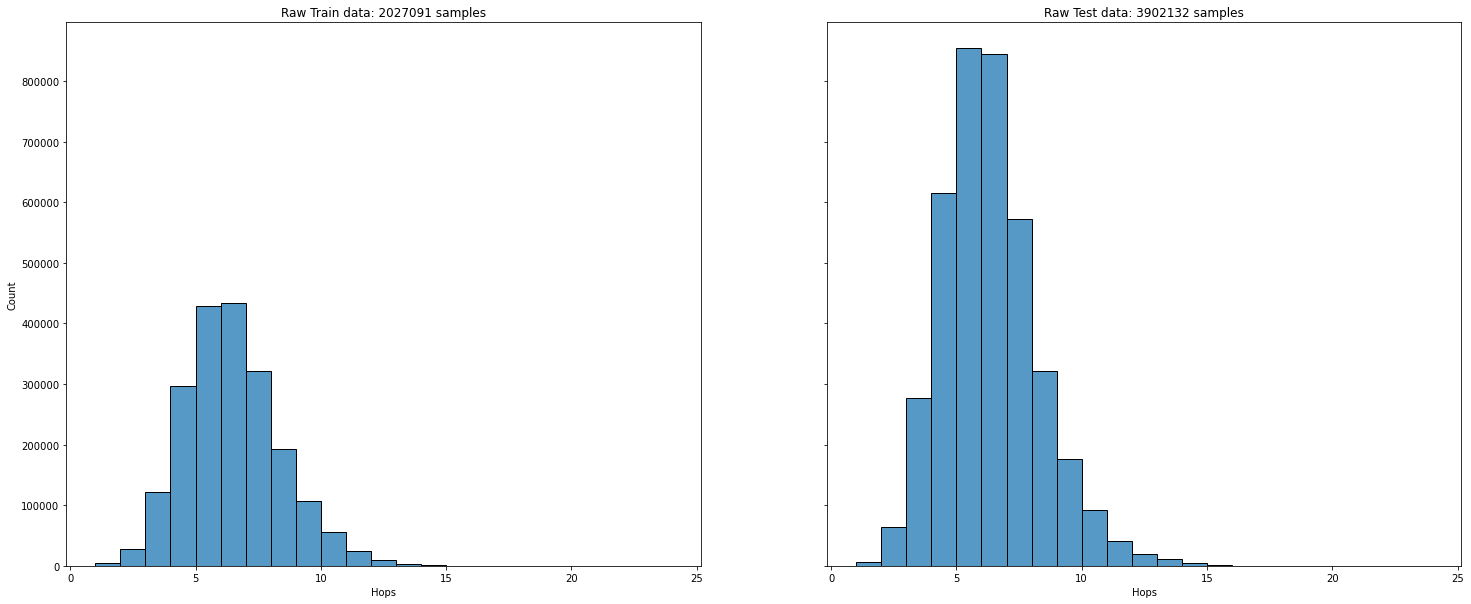

Balanced Train data: 54739 samples
Validation data: 5278 samples


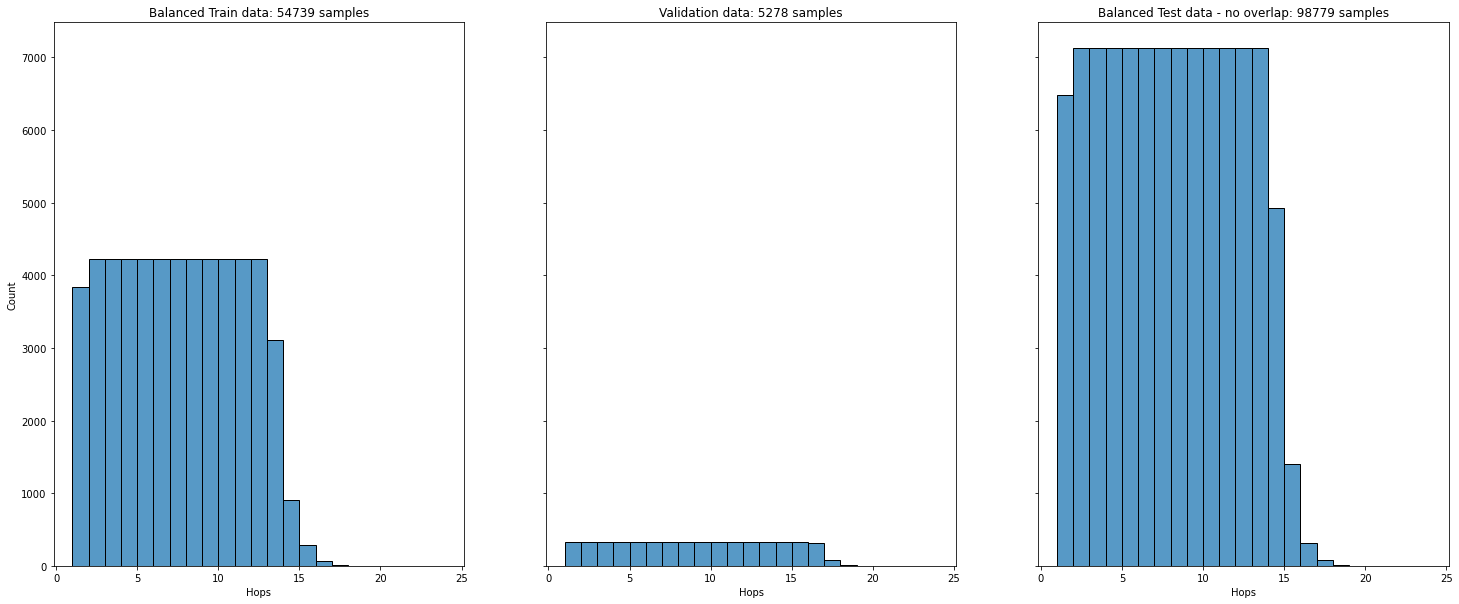

                                                  Head  \
1640076                              C5, complement C5   
1703612                                 LPIN1, lipin 1   
1049839                                    15(S)-HPETE   
921359                         sn-Glycerol 3-phosphate   
22191                      beta-D-Fructose 6-phosphate   
...                                                ...   
852758               (Glc)1 (GlcNAc)2 (Man)9 (PP-Dol)1   
828687      MOGS, mannosyl-oligosaccharide glucosidase   
854291                   Dolichyl D-glucosyl phosphate   
829643      MOGS, mannosyl-oligosaccharide glucosidase   
832738   ALG10B, ALG10 alpha-1,2-glucosyltransferase B   

                                                      Tail      Hops  
1640076                            Complement component 4b  1.000000  
1703612                 TRA2A, transformer 2 alpha homolog  1.000000  
1049839                                     15H-11,12-EETA  1.000000  
921359   ADPRM, ADP

In [10]:
def squared(Hops):
    return Hops**2

def no_transform(Hops):
    return Hops

def make_binary(Hops):
    temp = 1/Hops
    return np.floor(temp)
    

y_transform = inverse_transform
# y_transform = make_binary
x_train,y_train,x_valid,y_valid,x_sub_train,y_sub_train,x_test_balanced,y_test_balanced = Load_Datasets(
     'v8',y_transform = y_transform, Max_Hops_Samples_relativeToHop1 = 1.1, ValidationPercentageSplit = 0.05, SubTrainPercentage = 0.05)

# Define Model Architecture

In [8]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(2*384, 512), nn.ReLU(), nn.Dropout(0.1),
#             nn.Linear(1984, 1866), nn.ReLU(), nn.Dropout(0.249),
#             nn.Linear(1866, 680), nn.ReLU(), nn.Dropout(0.305),
#             nn.Linear(680,1921), nn.ReLU(), nn.Dropout(0.332),
            nn.Linear(512, 1)
            )

    def forward(self, *inputs, **args):
        logits = self.linear_relu_stack(torch.stack(list(inputs), dim=0))
        return logits
    
    
class ConvNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            torch.nn.Conv2d(in_channels=4, out_channels=16, kernel_size=(3, 3), padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d((2, 2)),
            torch.nn.Conv2d(in_channels=16, out_channels=64, kernel_size=(3, 3), padding=1),
            torch.nn.ReLU(),
            torch.nn.Flatten(),
            nn.Linear(24576, 1280), nn.ReLU(), nn.Dropout(0.1),
            nn.Linear(1280, 512), nn.ReLU(), nn.Dropout(0.1),
            nn.Linear(512, 1)
            )

    def forward(self, *inputs, **args):
        logits = self.linear_relu_stack(torch.stack(list(inputs), dim=0))
        return logits

# Load Embeddings Dictionary  
import pickle
# with open('node_embeddings_dict.pkl', 'rb') as f:
with open('node_embeddings_dict_BioFormer.pkl', 'rb') as f:
    embeddings_dict = pickle.load(f)
    
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# Function to prepare input data for above model
def FE_inputs(inputs_list):
    input_embeddings = []
    for row in inputs_list:
        X_ls = row.split(' [SEP] ')
        input_embeddings.append(np.append(embeddings_dict[X_ls[0]],embeddings_dict[X_ls[1]]))
    return torch.FloatTensor(np.array(input_embeddings)).to(DEVICE)

def FE_inputs_conv2d(inputs_list):
    input_embeddings = []
    for row in inputs_list:
        X_ls = row.split(' [SEP] ')
        ch11 = np.array(embeddings_dict[X_ls[0]][0:768])
        ch12 = np.array(embeddings_dict[X_ls[0]][768:1536])
        ch13 = np.array(embeddings_dict[X_ls[0]][1536:2304])
        ch14 = np.array(embeddings_dict[X_ls[0]][2304:3072])
        ch21 = np.array(embeddings_dict[X_ls[1]][0:768])
        ch22 = np.array(embeddings_dict[X_ls[1]][768:1536])
        ch23 = np.array(embeddings_dict[X_ls[1]][1536:2304])
        ch24 = np.array(embeddings_dict[X_ls[1]][2304:3072])
        ch1 = np.append(ch11, ch21).reshape(48,32)
        ch2 = np.append(ch12, ch22).reshape(48,32)
        ch3 = np.append(ch13, ch23).reshape(48,32)
        ch4 = np.append(ch14, ch24).reshape(48,32)
        
        input_embeddings.append([ch1, ch2, ch3, ch4])
    return torch.FloatTensor(np.array(input_embeddings)).to(DEVICE)


# Hyper-parameters and Train

In [6]:
from torchmetrics import MeanAbsolutePercentageError

# Custom loss function
def custom_loss(output, target):
#     loss = torch.mean(((output - target)**2)) # MSE
#     loss = torch.mean(((output - target)**2)*(target+0.01/target)) # More attention to low hops
    loss = torch.mean(((output - target)**2)*target)
    return loss

def save_for_best_loss(metrics):
    return metrics["loss"]

# Hyper parameters
epochs = 15
LR = 2e-4
BSZ = 32
# criterion = MeanAbsolutePercentageError().to('cpu')
criterion = custom_loss
model = NeuralNetwork()
# model = ConvNetwork()
optimizer = optim.Adam(model.parameters(), lr=LR)
# optimizer = optim.RMSprop(model.parameters(), lr=LR)
# print(model)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)

# Data Loaders
train_loader = DataLoader(tuple(zip(x_train,y_train)), batch_size=BSZ, shuffle=True)
sub_train_loader = DataLoader(tuple(zip(x_sub_train,y_sub_train)), batch_size=1, shuffle=True)
valid_loader = DataLoader(tuple(zip(x_valid,y_valid)), batch_size=1, shuffle=True)

# Train and Test(sub-test)
_,stopping_epoch = AIO(model, FE_inputs, train_loader, valid_loader, epochs, criterion, optimizer, scheduler,'PubMedBERT', save_criterion_func = save_for_best_loss, train_loader2 = sub_train_loader)
print(stopping_epoch)

Couldn't make new directory PubMedBERT, it already exists?
Epoch 1


  0%|          | 0/1328 [00:00<?, ?it/s]

KeyError: 'IL24, interleukin 24'

# Final Tests

Test trained model on balanced test set - no common nodes with train


  0%|          | 0/98779 [00:00<?, ?it/s]


Test Results:
Loss: 0.022412
Total Mean Squared Error: 0.0681
Total Mean Absolute Error: 0.2145

 Hop '1'	MAE: 0.4362, MSE: 0.2100
 Hop '2'	MAE: 0.1150, MSE: 0.0200
 Hop '3'	MAE: 0.2094, MSE: 0.0570
0.08304715530497181

Percentage of prediction > 0.5: 
 Hop  1: 	70.7453%
 Hops 2-3: 	64.6093%
 Hops 4-10: 	21.8905%
 Hops 11+: 	4.9330%

Pseudo binary metrics (ignoring Hops 2 & 3): 
Precision: 	27.1350%
Recall: 	70.7453%
Accuracy: 	83.1900%
f1: 	39.2249%
f1 Gain: 	85.9673%


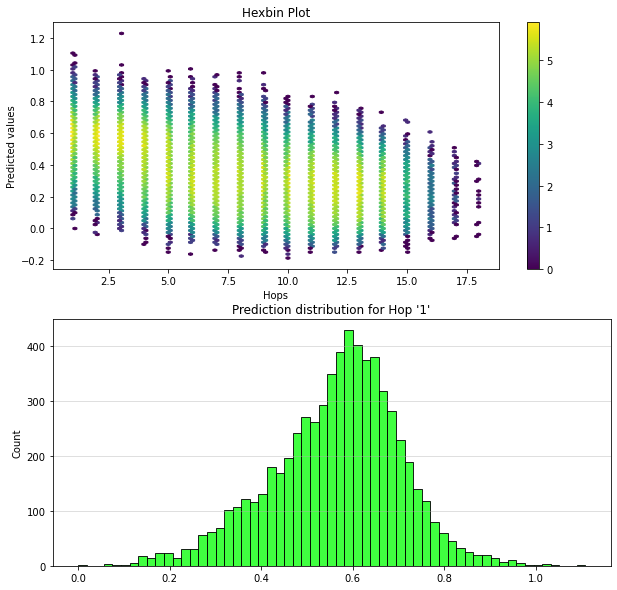

In [11]:
# Loader for final testing (balanced)
test_balanced_loader = DataLoader(tuple(zip(x_test_balanced,y_test_balanced)), batch_size=1, shuffle=True)

# Load Best version for testing
model_PMB = torch.load("./PubMedBERT/Model.pth")#, map_location=torch.device('cpu'))
model_PMB.eval()
print("Test trained model on balanced test set - no common nodes with train")
balanced_test_metrics = test_model(model_PMB, FE_inputs, test_balanced_loader, criterion)

Test model on all original train data


  0%|          | 0/54739 [00:00<?, ?it/s]


Test Results:
Loss: 0.019800
Total Mean Squared Error: 0.0571
Total Mean Absolute Error: 0.1919

 Hop '1'	MAE: 0.3784, MSE: 0.1643
 Hop '2'	MAE: 0.1338, MSE: 0.0258
 Hop '3'	MAE: 0.2158, MSE: 0.0594
0.09057706355003653

Percentage of prediction > 0.5: 
 Hop  1: 	81.8418%
 Hops 2-3: 	69.4536%
 Hops 4-10: 	19.7560%
 Hops 11+: 	3.6206%

Pseudo binary metrics (ignoring Hops 2 & 3): 
Precision: 	33.2628%
Recall: 	81.8418%
Accuracy: 	84.8541%
f1: 	47.3012%
f1 Gain: 	88.9036%


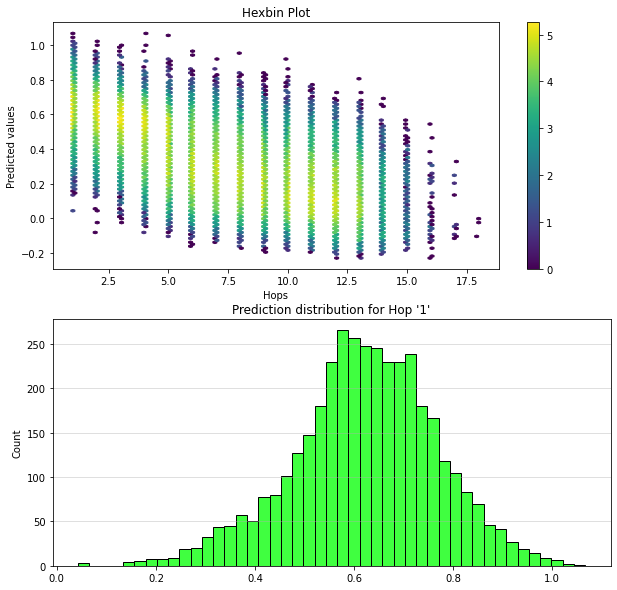

In [12]:
print("Test model on all original train data")
train_loader_for_testing = DataLoader(tuple(zip(x_train,y_train)), batch_size=1, shuffle=True)
balanced_train_metrics = test_model(model_PMB, FE_inputs, train_loader_for_testing, criterion)

In [ ]:
print("Test model on all distant pairs") 
data_dis = pd.read_csv('Distant pairs Undirected.csv', header=0)
data_dis = data_dis[data_dis["Hops"]>11] # >11 to reduce time

data_dis["Hops"] = y_transform(data_dis["Hops"])
y_test_dis = pd.to_numeric(data_dis.Hops)#.astype(int)
x_test_dis = np.vectorize(joining)(data_dis.Head.astype(str),data_dis.Tail.astype(str))

distant_loader = DataLoader(tuple(zip(x_test_dis,y_test_dis)), batch_size=1, shuffle=True)
distant_pairs_metrics = test_model(model_PMB, FE_inputs, distant_loader, criterion)

In [ ]:
# temp = pd.DataFrame([last_epoch, balanced_test_metrics, balanced_train_metrics, distant_pairs_metrics])
# temp.to_csv('testout.csv')